[Real or Not ? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

##### Goal - In this competition we are challenged to build a ML model that predicts which Tweets are about and which one's aren't.

##### Importing required python libraries

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from wordcloud import WordCloud
import re
from nltk.tokenize import word_tokenize
#import gensim
import string
import os
import warnings

In [32]:
pd.set_option('display.max_colwidth',None)
warnings.filterwarnings(action='ignore', category=FutureWarning)

#### Loading the train and test data

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train.sample(5)

,id,keyword,location,text,target
4815,6854,mass%20murder,New Sweden,The media needs to stop publicizing mass murde...,1
448,651,attack,NaN,http://t.co/pTKrXtZjtV Nashville Theater Atta...,1
4095,5821,hail,Calgary,@weathernetwork here comes the hail!,1
7414,10607,wounded,"Suva, Fiji Islands.",GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0
4261,6055,heat%20wave,Somewhere in Spain,@KlaraJoelsson Well I have seen it now! That's...,1


#### Target Class distribution

<AxesSubplot:>

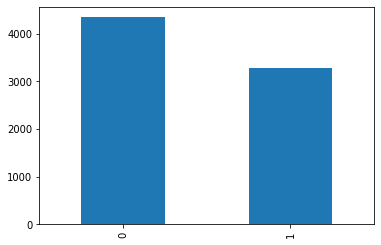

In [6]:
train.target.value_counts().plot(kind='bar', y)

As expected, there are more tweets with class 0 (No disaster) than class 1 (disaster)

#### EDA of Tweets

<Number of Characters>

**Number of characters in tweets**

In [8]:
train['tweet_len'] = train['text'].apply(lambda x: len(x))

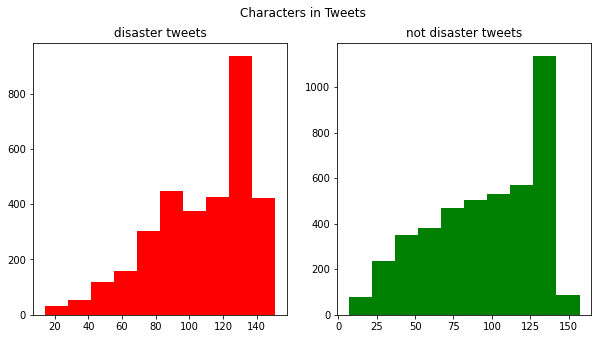

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.hist(train[train.target==1]['tweet_len'], color='red')
ax1.set_title('disaster tweets')
ax2.hist(train[train.target==0]['tweet_len'], color='green')
ax2.set_title('not disaster tweets')
fig.suptitle('Characters in Tweets')
plt.show()

**Number of words in a tweet**

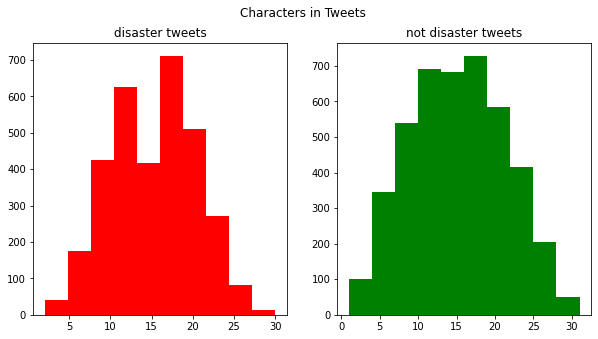

In [26]:
train['tweet_words'] = train['text'].str.split().map(lambda x: len(x))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.hist(train[train.target==1]['tweet_words'], color='red')
ax1.set_title('disaster tweets')
ax2.hist(train[train.target==0]['tweet_words'], color='green')
ax2.set_title('not disaster tweets')
fig.suptitle('Characters in Tweets')
plt.show()

**Average word length in a tweet**

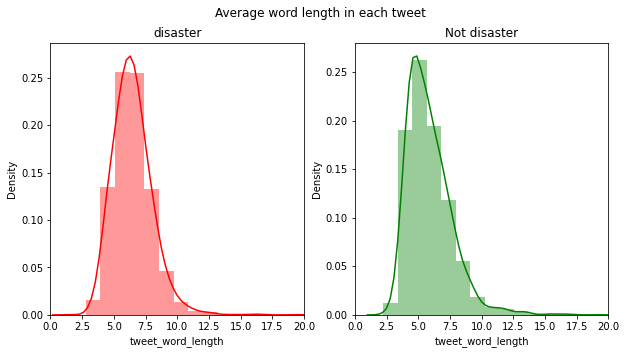

In [38]:
train['tweet_word_length'] = train['text'].str.split(' ').map(lambda x: [len(i) for i in x])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_xlim(0,20)
ax2.set_xlim(0,20)
sns.distplot(train[train.target==1]['tweet_word_length'].map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
sns.distplot(train[train.target==0]['tweet_word_length'].map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')
plt.show()

**Corpus creation**

In [94]:
def create_corpus(target:int)->list:
    corpus = []
    tweet = train[train.target==target]['text'].str.split()
    corpus = [i.lower() for x in tweet for i in x]
    return corpus

**Common words in disaster and non-disaster tweets**

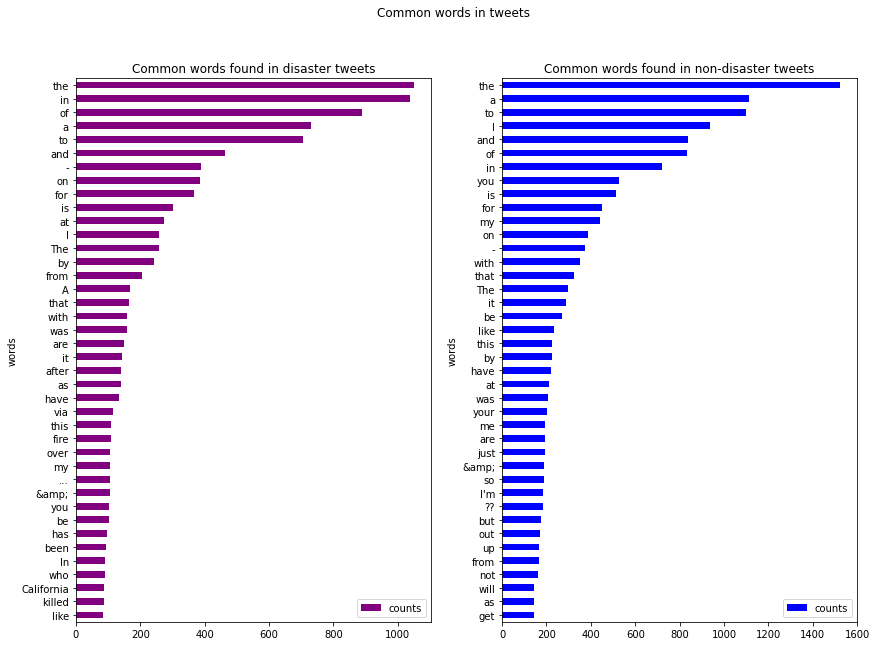

In [56]:
corpus = create_corpus(1)
counter = Counter(corpus)
most = counter.most_common(40)
most = pd.DataFrame(most, columns=['words','counts'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 10))
most.sort_values(by='counts').plot.barh(x='words',y='counts',ax=ax1, color='purple')
ax1.set_title('Common words found in disaster tweets')
corpus = create_corpus(0)
counter = Counter(corpus)
most = counter.most_common(40)
most = pd.DataFrame(most, columns=['words','counts'])
most.sort_values(by='counts').plot.barh(x='words',y='counts',ax=ax2, color='blue')
ax2.set_title('Common words found in non-disaster tweets')
fig.suptitle('Common words in tweets')
plt.show()

Analyze punctuations

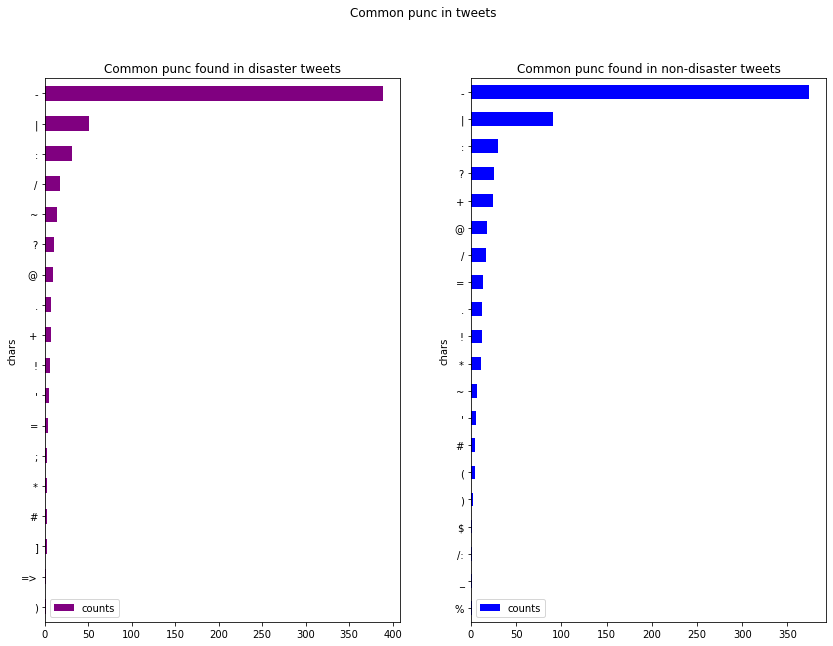

In [65]:
punc = string.punctuation
corpus = create_corpus(1)
corpus = [i for i in corpus if i in punc]
counter = Counter(corpus)
most = counter.most_common()
most = pd.DataFrame(most, columns=['chars','counts'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 10))
most.sort_values(by='counts').plot.barh(x='chars',y='counts',ax=ax1, color='purple')
ax1.set_title('Common punc found in disaster tweets')
corpus = create_corpus(0)
corpus = [i for i in corpus if i in punc]
counter = Counter(corpus)
most = counter.most_common()
most = pd.DataFrame(most, columns=['chars','counts'])
most.sort_values(by='counts').plot.barh(x='chars',y='counts',ax=ax2, color='blue')
ax2.set_title('Common punc found in non-disaster tweets')
fig.suptitle('Common punc in tweets')
plt.show()

#### Cleaning the Corpus

In [68]:
def remove_urls(text:str)->str:
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [69]:
def remove_html_tags(text:str)->str:
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [70]:
def remove_emojis(text:str)->str:
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [71]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
def convert_abbrev(text:str)->str:
    tokens = word_tokenize(text)
    tokens = [abbreviations.get(word.lower(),word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [92]:
addnl_stop_words = ["retweet","n't","one","today","day","year","time","can't","amp","say","area","city","got","people",
                   "man","look","still","im","say","last","thing","job","via"]
def remove_stop_words(corpus:list)->list:
    stop = stopwords.words('English')
    stop = stop + addnl_stop_words
    corpus = [i for i in corpus if i not in stop]
    return corpus

In [73]:
def remove_punc(corpus:list)->list:
    punc = string.punctuation
    corpus = [i for i in corpus if i not in punc]
    return corpus

In [ ]:
#def spell_checker(corpus:list)->list:

#### Word Cloud

In [75]:
train['text'] = train['text'].apply(lambda x: remove_urls(x))
train['text'] = train['text'].apply(lambda x: remove_html_tags(x))
train['text'] = train['text'].apply(lambda x: remove_emojis(x))
train['text'] = train['text'].apply(lambda x: convert_abbrev(x))

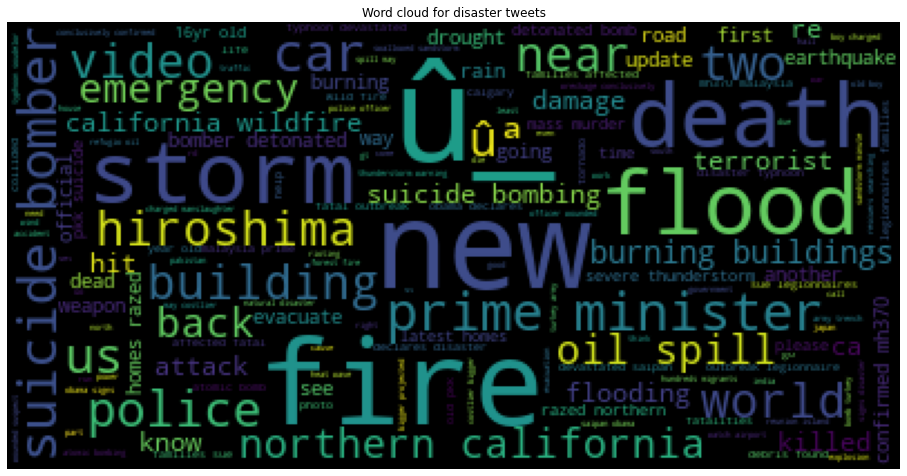

In [95]:
corpus = create_corpus(1)
corpus = remove_stop_words(corpus)
corpus = remove_punc(corpus)
plt.figure(figsize=(16,12))
word_cloud = WordCloud(max_font_size=60).generate(" ".join(corpus))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Word cloud for disaster tweets')
plt.show()

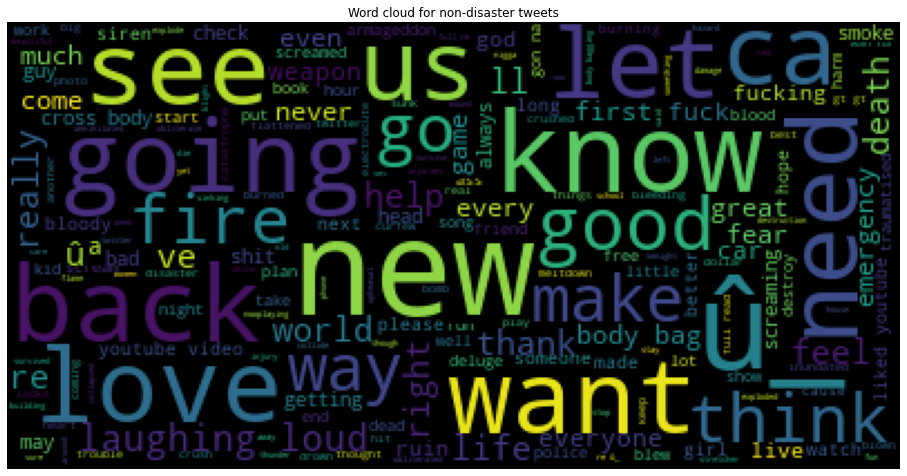

In [96]:
corpus = create_corpus(0)
corpus = remove_stop_words(corpus)
corpus = remove_punc(corpus)
plt.figure(figsize=(16,12))
word_cloud = WordCloud(max_font_size=60).generate(" ".join(corpus))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Word cloud for non-disaster tweets')
plt.show()

### Feature Engineering

CountVectorizer